# Take 2 on your plate analyses
In this notebook I show some examples of how to use the "new and improved" interface for analysing your plates.
Instead of individual functions in a file, I have made a class called `Plate`, which represents one plate experiment.
This class comes with its own methods for getting the data into the desirable long format, visualizing the curves, doing curve fitting and
computing area under the curve. It also comes with functionality making it easy to add metadata to the DataFrames, and for adding two different `Plates` together.

In `models.py` a couple of curve fitting models can be found:
* `LogisticSymmetric`: A simple logistic function with (4 parameters)
* `Richards`: A generalized logistic function that allows for some asymmetry (5 parameters)
* `RichardsModified`: Default. A modified version of the `Richards` model (6 parameters)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

from plate import Plate
from models import LogisticSymmetric, Richards, RichardsModified

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

# Creating a `Plate` object
The `Plate` class takes two mandatory arguments (in the following order):
* Path to a CSV file containing the plate layout
* Path to a CSV file containing the wide-form raw data

In addition, you can pass an `ID` which will be stored with the object, and added as metadata to the dataframes.

Several things take place when you create a `Plate`:
1. The template is congert to a DataFrame
2. The wide-form is converted to a DataFrame
3. A long-form version of the data is made as a second DataFrame
4. The replicates are combined into a third DataFrame

The wide-form DataFrame is not used as anything, except as a starting point. All analyses are done on the long-form and combined-form.

This is how you make a `Plate` object:

In [2]:
template = 'Templates/Template_pseudomonas.csv'
wide = 'Datasets/Pseudomonas_Sp_mr4-99_Round1_.csv'
plate = Plate(template, wide, blank_name='Blank', ID='Pseudomonas')

Pseudomonas


In [3]:
plate.ID

'Pseudomonas'

# Retrieving the data

You can access the three DataFrames in the following way:
* `plate.wide`
* `plate.long`
* `plate.combined`

In [4]:
plate.wide.head()

,Time,Time_hours,Temp,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11
0,00:00:00,0.00,25.0,0.116,0.116,0.115,0.125,0.110,0.118,0.111,0.112,0.112,0.129,0.111,0.116,0.128,0.113,0.116,0.117,0.114,0.114,0.112,0.118,0.111,0.114,0.118,0.112,0.109,0.115,0.116,0.114,0.123,0.120,0.116,0.119,0.118,0.123,0.118,0.116,0.117,0.114,0.122,0.121,0.114,0.114,0.113,0.121,0.114,0.120,0.116,0.111,0.117,0.122,0.117,0.120,0.115,0.119,0.125,0.123,0.115,0.117,0.115,0.120
1,00:14:32,0.25,25.0,0.121,0.119,0.119,0.128,0.115,0.123,0.115,0.115,0.115,0.132,0.114,0.119,0.130,0.116,0.120,0.121,0.117,0.118,0.118,0.120,0.115,0.117,0.122,0.114,0.113,0.119,0.121,0.118,0.123,0.123,0.120,0.122,0.121,0.127,0.123,0.121,0.119,0.119,0.125,0.122,0.117,0.116,0.116,0.123,0.118,0.124,0.118,0.113,0.119,0.125,0.122,0.124,0.118,0.123,0.128,0.125,0.118,0.119,0.118,0.121
2,00:29:35,0.50,25.1,0.123,0.121,0.121,0.129,0.117,0.125,0.115,0.115,0.116,0.134,0.116,0.121,0.131,0.119,0.122,0.124,0.120,0.120,0.121,0.121,0.117,0.119,0.124,0.117,0.114,0.120,0.124,0.121,0.125,0.125,0.124,0.124,0.123,0.128,0.125,0.123,0.123,0.121,0.126,0.123,0.122,0.122,0.122,0.125,0.122,0.128,0.119,0.114,0.120,0.127,0.124,0.126,0.120,0.124,0.130,0.128,0.118,0.120,0.118,0.123
3,00:44:38,0.75,25.3,0.126,0.123,0.123,0.130,0.119,0.127,0.116,0.117,0.117,0.136,0.118,0.123,0.132,0.122,0.124,0.126,0.121,0.121,0.123,0.123,0.118,0.121,0.126,0.119,0.116,0.123,0.125,0.123,0.126,0.127,0.123,0.126,0.124,0.130,0.127,0.125,0.133,0.126,0.126,0.125,0.124,0.123,0.122,0.127,0.124,0.130,0.121,0.115,0.121,0.129,0.126,0.130,0.122,0.127,0.132,0.129,0.119,0.120,0.119,0.125
4,00:59:41,1.00,25.5,0.128,0.126,0.125,0.132,0.121,0.129,0.118,0.118,0.118,0.139,0.121,0.125,0.134,0.125,0.126,0.127,0.126,0.125,0.126,0.125,0.121,0.123,0.129,0.124,0.119,0.124,0.128,0.124,0.130,0.130,0.127,0.128,0.126,0.136,0.129,0.128,0.171,0.151,0.127,0.127,0.125,0.124,0.125,0.130,0.127,0.132,0.123,0.117,0.120,0.133,0.129,0.133,0.125,0.130,0.134,0.131,0.120,0.122,0.119,0.127


In [5]:
plate.long.head()

,Time_hours,Temp,Well,Absorption,Group,ID
0,0.00,25.0,B2,0.116,Glucose,Pseudomonas
1,0.25,25.0,B2,0.121,Glucose,Pseudomonas
2,0.50,25.1,B2,0.123,Glucose,Pseudomonas
3,0.75,25.3,B2,0.126,Glucose,Pseudomonas
4,1.00,25.5,B2,0.128,Glucose,Pseudomonas


In [6]:
plate.combined.head()

,Time_hours,Temp_Mean,Temp_StDev,n,Mean,StDev,Group,logMean,logStDevUpper,logStDevLower,ID
0,0.00,25.0,0.000000e+00,3.0,0.115667,0.000577,Glucose,-3.111955,-3.104772,-3.119174,Pseudomonas
1,0.25,25.0,0.000000e+00,3.0,0.119667,0.001155,Glucose,-3.062907,-3.049052,-3.076895,Pseudomonas
2,0.50,25.1,4.351168e-15,3.0,0.121667,0.001155,Glucose,-3.038994,-3.025367,-3.052752,Pseudomonas
3,0.75,25.3,0.000000e+00,3.0,0.124000,0.001732,Glucose,-3.011588,-2.991576,-3.031882,Pseudomonas
4,1.00,25.5,0.000000e+00,3.0,0.126333,0.001528,Glucose,-2.984693,-2.967353,-3.002243,Pseudomonas


Additionally, you can extract x and y data easily from a sub-group of the combined DataFrame like shown below.
You can get either the log-transformed mean values, or the un-transformed mean values.

In [7]:
x, y = plate.get_xy('Glucose', log=False)
# x, y = plate.get_xy('Glucose', log=True)

In [8]:
x.head()

0    0.00
1    0.25
2    0.50
3    0.75
4    1.00
Name: Time_hours, dtype: float64

In [9]:
y.head()

0    0.115667
1    0.119667
2    0.121667
3    0.124000
4    0.126333
Name: Mean, dtype: float64

# Adding metadata
If you want to add metadata to the long and combined DataFrames, you can use the `add_metadata` method.
The first argument is the column name, and the second argument is the value.
The value is always added to all rows.

There is also a method for removing metadata: `remove_metadata(Parametername)`. The column matching
`Parametername` will be dropped inplace.

In [10]:
plate.add_metadata('Parameter1', 'Value1')

In [11]:
plate.long.head()

,Time_hours,Temp,Well,Absorption,Group,ID,Parameter1
0,0.00,25.0,B2,0.116,Glucose,Pseudomonas,Value1
1,0.25,25.0,B2,0.121,Glucose,Pseudomonas,Value1
2,0.50,25.1,B2,0.123,Glucose,Pseudomonas,Value1
3,0.75,25.3,B2,0.126,Glucose,Pseudomonas,Value1
4,1.00,25.5,B2,0.128,Glucose,Pseudomonas,Value1


In [12]:
plate.combined.head()

,Time_hours,Temp_Mean,Temp_StDev,n,Mean,StDev,Group,logMean,logStDevUpper,logStDevLower,ID,Parameter1
0,0.00,25.0,0.000000e+00,3.0,0.115667,0.000577,Glucose,-3.111955,-3.104772,-3.119174,Pseudomonas,Value1
1,0.25,25.0,0.000000e+00,3.0,0.119667,0.001155,Glucose,-3.062907,-3.049052,-3.076895,Pseudomonas,Value1
2,0.50,25.1,4.351168e-15,3.0,0.121667,0.001155,Glucose,-3.038994,-3.025367,-3.052752,Pseudomonas,Value1
3,0.75,25.3,0.000000e+00,3.0,0.124000,0.001732,Glucose,-3.011588,-2.991576,-3.031882,Pseudomonas,Value1
4,1.00,25.5,0.000000e+00,3.0,0.126333,0.001528,Glucose,-2.984693,-2.967353,-3.002243,Pseudomonas,Value1


In [13]:
plate.remove_metadata('Parameter1')
plate.combined.head()

,Time_hours,Temp_Mean,Temp_StDev,n,Mean,StDev,Group,logMean,logStDevUpper,logStDevLower,ID
0,0.00,25.0,0.000000e+00,3.0,0.115667,0.000577,Glucose,-3.111955,-3.104772,-3.119174,Pseudomonas
1,0.25,25.0,0.000000e+00,3.0,0.119667,0.001155,Glucose,-3.062907,-3.049052,-3.076895,Pseudomonas
2,0.50,25.1,4.351168e-15,3.0,0.121667,0.001155,Glucose,-3.038994,-3.025367,-3.052752,Pseudomonas
3,0.75,25.3,0.000000e+00,3.0,0.124000,0.001732,Glucose,-3.011588,-2.991576,-3.031882,Pseudomonas
4,1.00,25.5,0.000000e+00,3.0,0.126333,0.001528,Glucose,-2.984693,-2.967353,-3.002243,Pseudomonas


# Making graphs
Several graphing methods are implemented:
* `show()`: Visualize the plate layout
* `show_all_curves()`: Plot growth curves for all wells
* `show_combined_curves()`: Plot the means after combining replicates
* `show_fitted_curve()`: Make a fit on specified group and display original data overlayed with fit
* `show_fitted_curves()`: Same as above, but perform fit for all curves and display in a grid.
* `show_temperatures()`: Make a scatterplot of the temperatures throughout the experiment.

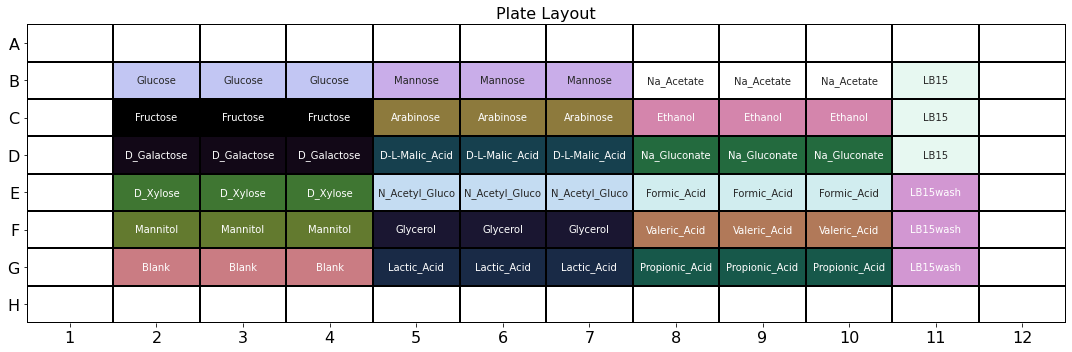

In [14]:
plate.show()

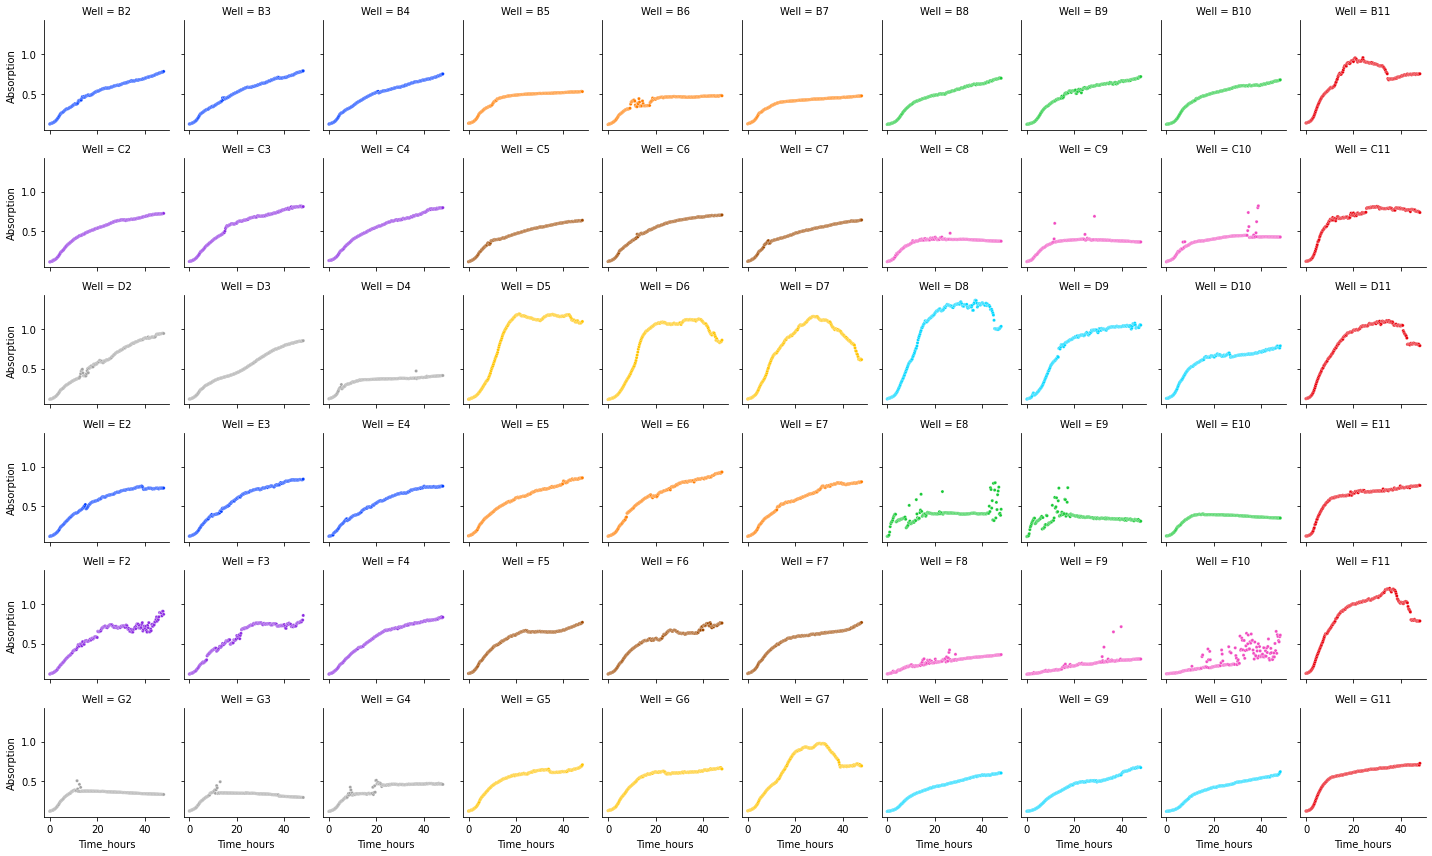

In [15]:
plate.show_all_curves()

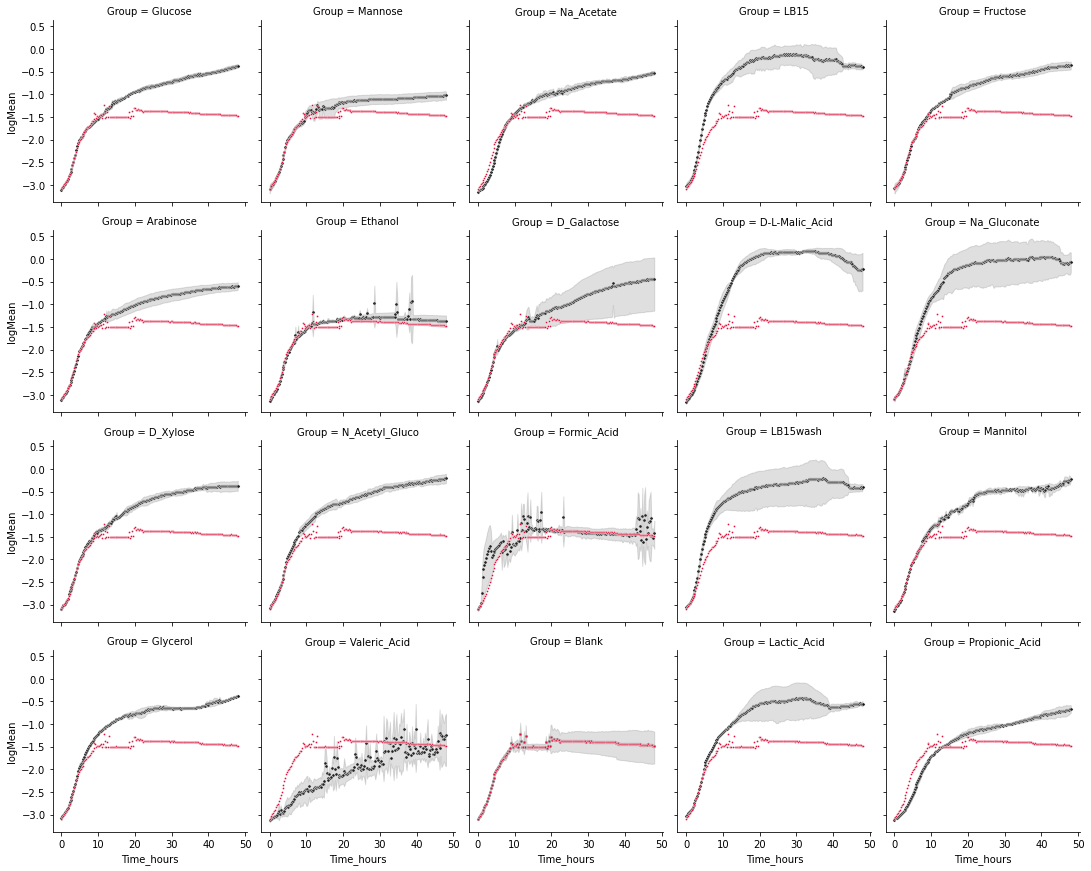

In [16]:
plate.show_combined_curves()

(<models.RichardsModified at 0x7fc69a13a820>,
 <AxesSubplot:xlabel='Time_hours', ylabel='logMean'>)

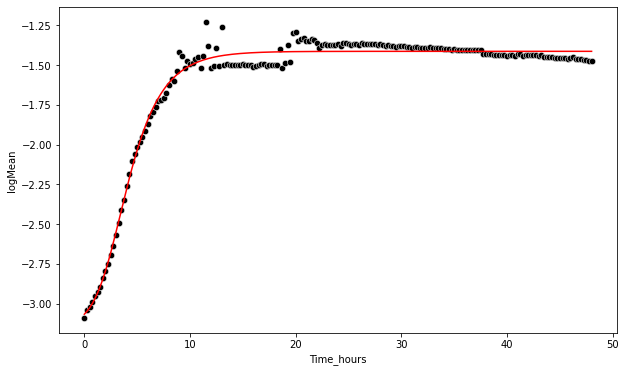

In [17]:
plate.show_fitted_curve(group='Blank')

({'Fructose': <models.RichardsModified at 0x7fc69a160df0>,
  'D_Galactose': <models.RichardsModified at 0x7fc69b2bd850>,
  'Glycerol': <models.RichardsModified at 0x7fc69b320b80>,
  'Lactic_Acid': <models.RichardsModified at 0x7fc69b327f40>,
  'D-L-Malic_Acid': <models.RichardsModified at 0x7fc69b329e20>,
  'Propionic_Acid': <models.RichardsModified at 0x7fc69b32d7c0>,
  'Na_Gluconate': <models.RichardsModified at 0x7fc69b32d610>,
  'D_Xylose': <models.RichardsModified at 0x7fc69b32df10>,
  'Mannitol': <models.RichardsModified at 0x7fc69b32deb0>,
  'Arabinose': <models.RichardsModified at 0x7fc69b32d8b0>,
  'Valeric_Acid': <models.RichardsModified at 0x7fc69b32dc10>,
  'Blank': <models.RichardsModified at 0x7fc69b32e310>,
  'Ethanol': <models.RichardsModified at 0x7fc69b32e250>,
  'LB15wash': <models.RichardsModified at 0x7fc69b32e3a0>,
  'Mannose': <models.RichardsModified at 0x7fc69b32e730>,
  'Glucose': <models.RichardsModified at 0x7fc69b32eee0>,
  'N_Acetyl_Gluco': <models.Richard

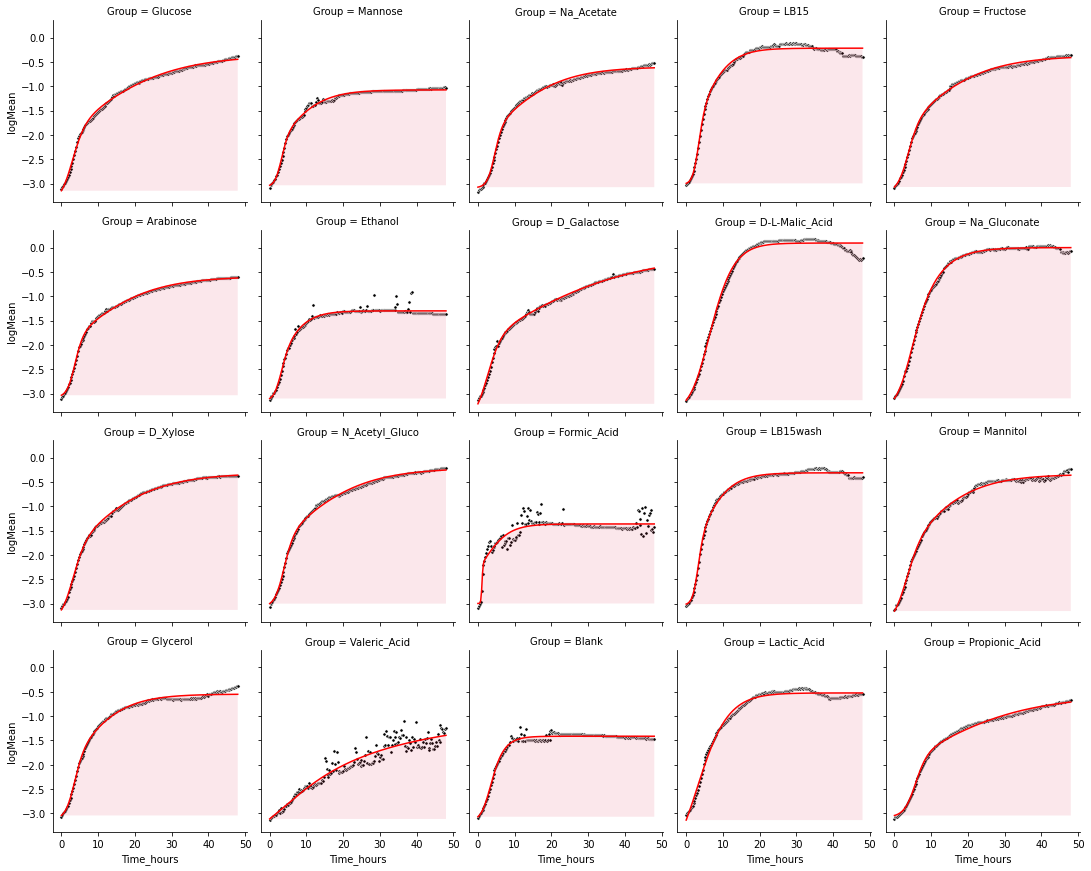

In [18]:
plate.show_fitted_curves()

<AxesSubplot:title={'center':'Temperatures'}, xlabel='Time_hours', ylabel='Temp_Mean'>

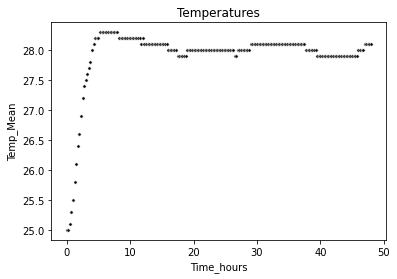

In [19]:
plate.show_temperatures()

# Fitting models
You can also fit models without plotting, both on a single group or on the whole plate, using the `fit_model()` method.
You must give a model name mathing either
* logisticsymmetric
* richards
* richardsmodified (default if not model name is given)

This method returns a `models` object, as defined in the corresponding model class located in `models.py`.
With this object you can extract useful information from the fitted model.

**Beware**: Currently, all model fitting can only be done on the log-transformed data.

In [20]:
model = plate.fit_model(group='Glycerol')

### Symbolic representations

In [21]:
model.symbolic_function()

L + (1 + exp(-k1*(x - x0)))**(-1/v)*(1 + exp(-k2*(x - x0)))**(-1/v)*(-L + U)

In [22]:
model.symbolic_first_derivative()

k1*(1 + exp(-k1*(x - x0)))**(-1/v)*(1 + exp(-k2*(x - x0)))**(-1/v)*(-L + U)*exp(-k1*(x - x0))/(v*(1 + exp(-k1*(x - x0)))) + k2*(1 + exp(-k1*(x - x0)))**(-1/v)*(1 + exp(-k2*(x - x0)))**(-1/v)*(-L + U)*exp(-k2*(x - x0))/(v*(1 + exp(-k2*(x - x0))))

In [23]:
model.symbolic_second_derivative()

-k1**2*(1 + exp(-k1*(x - x0)))**(-1/v)*(1 + exp(-k2*(x - x0)))**(-1/v)*(-L + U)*exp(-k1*(x - x0))/(v*(1 + exp(-k1*(x - x0)))) + k1**2*(1 + exp(-k1*(x - x0)))**(-1/v)*(1 + exp(-k2*(x - x0)))**(-1/v)*(-L + U)*exp(-2*k1*(x - x0))/(v*(1 + exp(-k1*(x - x0)))**2) + k1**2*(1 + exp(-k1*(x - x0)))**(-1/v)*(1 + exp(-k2*(x - x0)))**(-1/v)*(-L + U)*exp(-2*k1*(x - x0))/(v**2*(1 + exp(-k1*(x - x0)))**2) + 2*k1*k2*(1 + exp(-k1*(x - x0)))**(-1/v)*(1 + exp(-k2*(x - x0)))**(-1/v)*(-L + U)*exp(-k1*(x - x0))*exp(-k2*(x - x0))/(v**2*(1 + exp(-k1*(x - x0)))*(1 + exp(-k2*(x - x0)))) - k2**2*(1 + exp(-k1*(x - x0)))**(-1/v)*(1 + exp(-k2*(x - x0)))**(-1/v)*(-L + U)*exp(-k2*(x - x0))/(v*(1 + exp(-k2*(x - x0)))) + k2**2*(1 + exp(-k1*(x - x0)))**(-1/v)*(1 + exp(-k2*(x - x0)))**(-1/v)*(-L + U)*exp(-2*k2*(x - x0))/(v*(1 + exp(-k2*(x - x0)))**2) + k2**2*(1 + exp(-k1*(x - x0)))**(-1/v)*(1 + exp(-k2*(x - x0)))**(-1/v)*(-L + U)*exp(-2*k2*(x - x0))/(v**2*(1 + exp(-k2*(x - x0)))**2)

### Data that the model is based on

In [24]:
model.x.head()

2895    0.00
2896    0.25
2897    0.50
2898    0.75
2899    1.00
Name: Time_hours, dtype: float64

In [25]:
model.y.head()

2895   -3.079072
2896   -3.038994
2897   -3.000000
2898   -2.977100
2899   -2.947120
Name: logMean, dtype: float64

### Maximum growth rate

In [26]:
model.max_growth_rate()

0.3263225689693132

### Area under the curve
Note that the implementation is not simply the integral of the function from $a$ to $b$.
The area is computed as (with $f(x)$ being the model function)

$$
A = (b - a) \min(f(a)) - \int_a^b f(x) dx
$$

This is in order to get a more intuitive estimate of the area, and in this way the area corresponds to the shaded area shown in the fitted curves above.

In [27]:
model.area_under_curve()

100.93474772898993

### Optimized model parameters

In [28]:
model.popt

(-0.3591330756449052,
 -3.117531739921915,
 0.1471764695124646,
 0.7788639402538685,
 0.9652809898452285,
 3.1766073002981576)

### Fitting on a full plate
Not specifying a group means a model will be fitted to all groups, and a dictionary of `group: model` is returned.
You can iterate over the dictionary to, for example, get out the areas.

In [29]:
models = plate.fit_model()

In [30]:
for group, model in models.items():
    print(f'{group:20}{model.area_under_curve():.2f}')

Fructose            100.33
D_Galactose         94.96
Glycerol            100.93
Lactic_Acid         101.99
D-L-Malic_Acid      130.31
Propionic_Acid      84.27
Na_Gluconate        123.71
D_Xylose            101.75
Mannitol            106.07
Arabinose           94.97
Valeric_Acid        53.56
Blank               72.85
Ethanol             78.34
LB15wash            114.67
Mannose             83.00
Glucose             97.75
N_Acetyl_Gluco      105.97
Formic_Acid         76.88
LB15                118.00
Na_Acetate          96.71


# Performing a batch analyis
Lastly, the `analyze()` method can be used to go through all the plots and analyses in one go, and just print the results.
Perhaps this can be a quick way of summarizing the plate data.

`savefiles=True` will save all figures as PNGs and all displayed dataframes as CSVs.

Fitting models
Computing areas and rates


/Users/abr121/Documents/dev/Mikkel/venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


             Group         U         L        k1        k2         v            x0
0         Fructose -0.726520 -3.183172  0.097071  0.656985  1.069777  3.380788e+00
1      D_Galactose -0.686633 -3.587866  0.530422  0.051621  1.092899  2.256689e+00
2         Glycerol -0.359133 -3.117532  0.147176  0.778864  0.965281  3.176607e+00
3      Lactic_Acid -0.439229 -4.007032  0.241014  0.212632  0.988242  2.011132e-09
4   D-L-Malic_Acid  0.243118 -3.354195  0.283790  0.283781  0.979156  3.834091e+00
5   Propionic_Acid -1.314732 -3.073125  0.067198  0.633066  1.191984  5.440606e+00
6     Na_Gluconate -0.126031 -3.327056  0.436120  0.190540  1.019705  3.228399e+00
7         D_Xylose -0.653675 -3.360973  0.092485  0.579128  1.060648  2.701442e+00
8         Mannitol -0.925526 -3.419453  0.112106  0.517125  1.110621  2.653270e+00
9        Arabinose -0.630652 -3.077813  0.097093  0.895323  1.008023  3.476516e+00
10    Valeric_Acid -1.425348 -3.794162  0.041759  0.135289  1.072925  1.581713e-08
11  

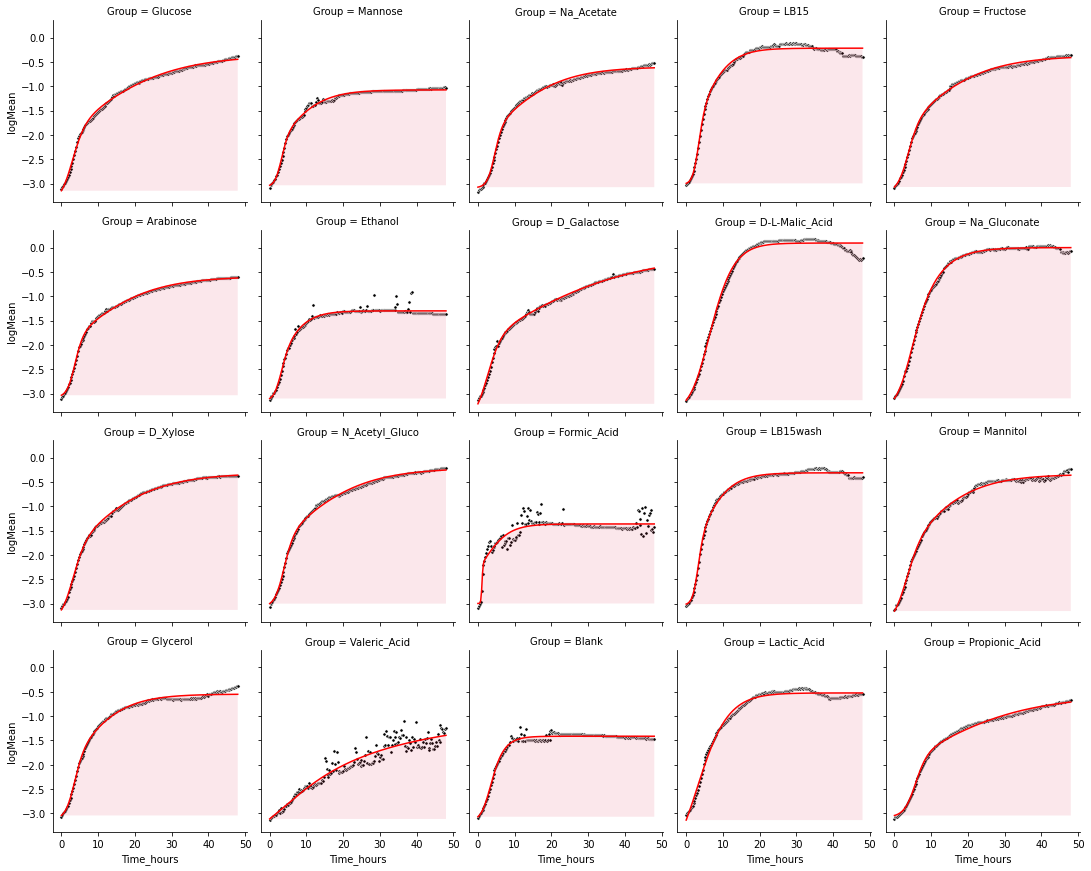

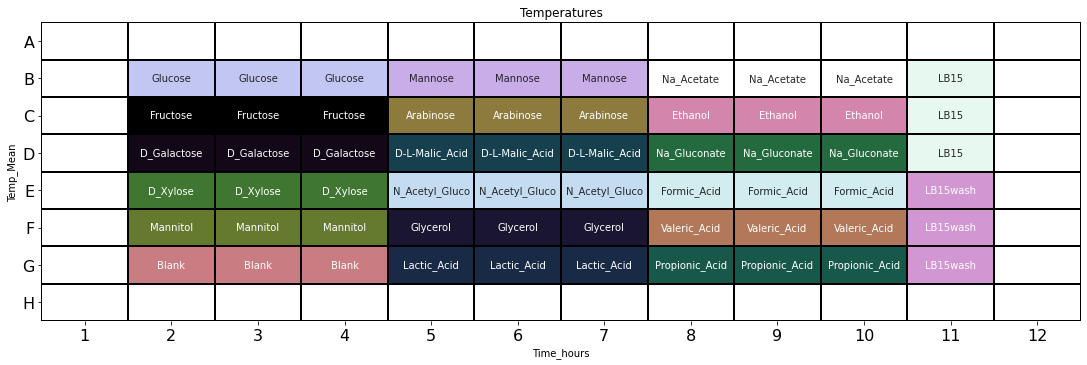

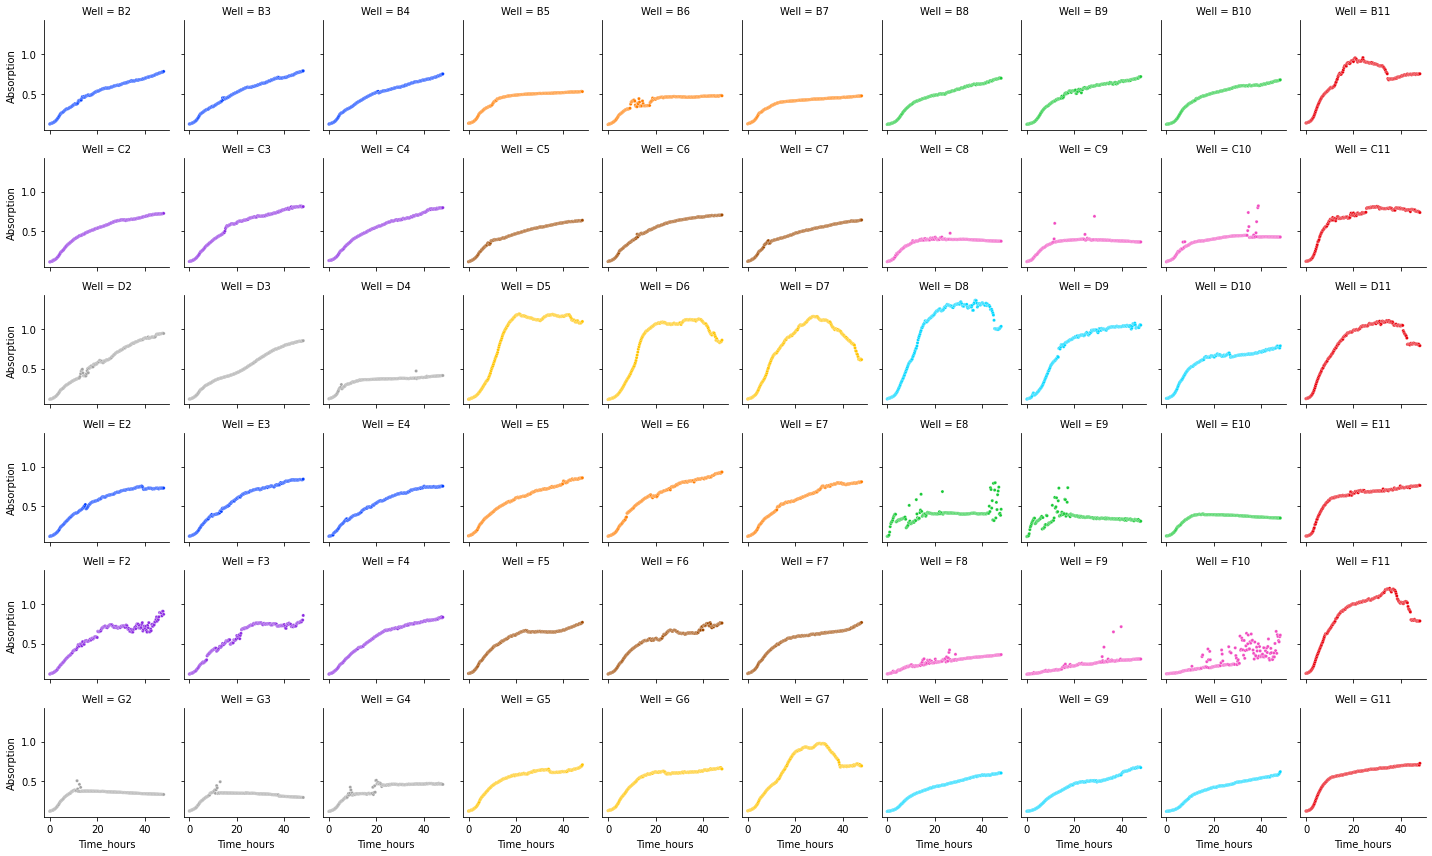

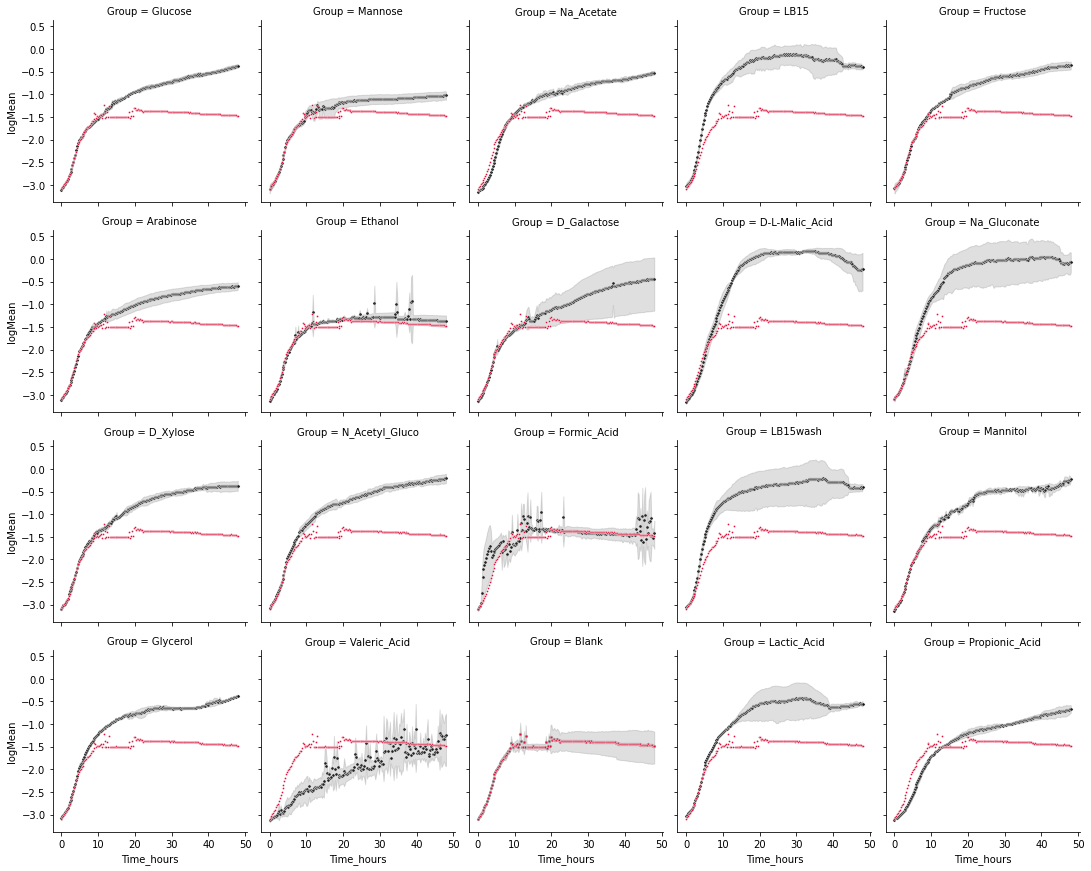

In [31]:
plate.analyze(savefiles=True)

# Combining multiple `Plates`
The `__add__` function in the class definition makes it easy to add two plates together.
What happens is that the `long` DataFrames for each `Plate` are concatenated, and the `combined` for each `Plate` are concatenated. 
These concatenated DataFrames are returned as a tuple.
Notice that the `ID`s passed to each plate are carried over to the concatenated ones.

**Note**: There must be the same number of columns in each DataFrame for this to work properly, so it will fail it you have added additional metadata to one Plate but not the other.

**Note**: Only `Pandas.DataFrame`s are returned when adding, and so all the functionality from the `Plate` class is lost.

**Note**: The group names in the two template files have to match *exactly* for `Seaborn` to "hue-match" correctly.

In [32]:
# Make a new Plate
template = 'Templates/Template_halomonas.csv'
wide = 'Datasets/Halomonas_Sp_r5-57_Round1_.csv'
plate2 = Plate(template, wide, blank_name='Blank', ID='Halomonas')

Halomonas


/Users/abr121/Documents/dev/Mikkel/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [33]:
combined_plate = plate + plate2

Pseudomonas+Halomonas


In [34]:
combined_plate.long

,Time_hours,Temp,Well,Absorption,Group,ID
0,0.00,25.0,B2,0.116,Glucose,Pseudomonas
1,0.25,25.0,B2,0.121,Glucose,Pseudomonas
2,0.50,25.1,B2,0.123,Glucose,Pseudomonas
3,0.75,25.3,B2,0.126,Glucose,Pseudomonas
4,1.00,25.5,B2,0.128,Glucose,Pseudomonas
...,...,...,...,...,...,...
20785,95.00,27.3,G10,0.128,Methanol,Halomonas
20786,95.25,27.3,G10,0.203,Methanol,Halomonas
20787,95.50,27.3,G10,0.161,Methanol,Halomonas
20788,95.75,27.3,G10,0.205,Methanol,Halomonas


In [35]:
combined_plate.combined

,Time_hours,Temp_Mean,Temp_StDev,n,Mean,StDev,Group,logMean,logStDevUpper,logStDevLower,ID
0,0.00,25.0,0.000000e+00,3.0,0.115667,0.000577,Glucose,-3.111955,-3.104772,-3.119174,Pseudomonas
1,0.25,25.0,0.000000e+00,3.0,0.119667,0.001155,Glucose,-3.062907,-3.049052,-3.076895,Pseudomonas
2,0.50,25.1,4.351168e-15,3.0,0.121667,0.001155,Glucose,-3.038994,-3.025367,-3.052752,Pseudomonas
3,0.75,25.3,0.000000e+00,3.0,0.124000,0.001732,Glucose,-3.011588,-2.991576,-3.031882,Pseudomonas
4,1.00,25.5,0.000000e+00,3.0,0.126333,0.001528,Glucose,-2.984693,-2.967353,-3.002243,Pseudomonas
...,...,...,...,...,...,...,...,...,...,...,...
6925,95.00,27.3,0.000000e+00,3.0,0.149667,0.019858,Methanol,-2.740175,-2.560434,-2.945539,Halomonas
6926,95.25,27.3,0.000000e+00,3.0,0.198667,0.007506,Methanol,-2.331578,-2.278078,-2.387139,Halomonas
6927,95.50,27.3,0.000000e+00,3.0,0.141000,0.022913,Methanol,-2.826233,-2.608999,-3.082076,Halomonas
6928,95.75,27.3,0.000000e+00,3.0,0.164667,0.050521,Methanol,-2.602380,-2.216335,-3.131047,Halomonas


### Looking at the differences between the two plates

Pseudomonas+Halomonas


(<seaborn.axisgrid.FacetGrid at 0x7fc69d591d30>,
 <plate.Plate at 0x7fc69d5ba400>)

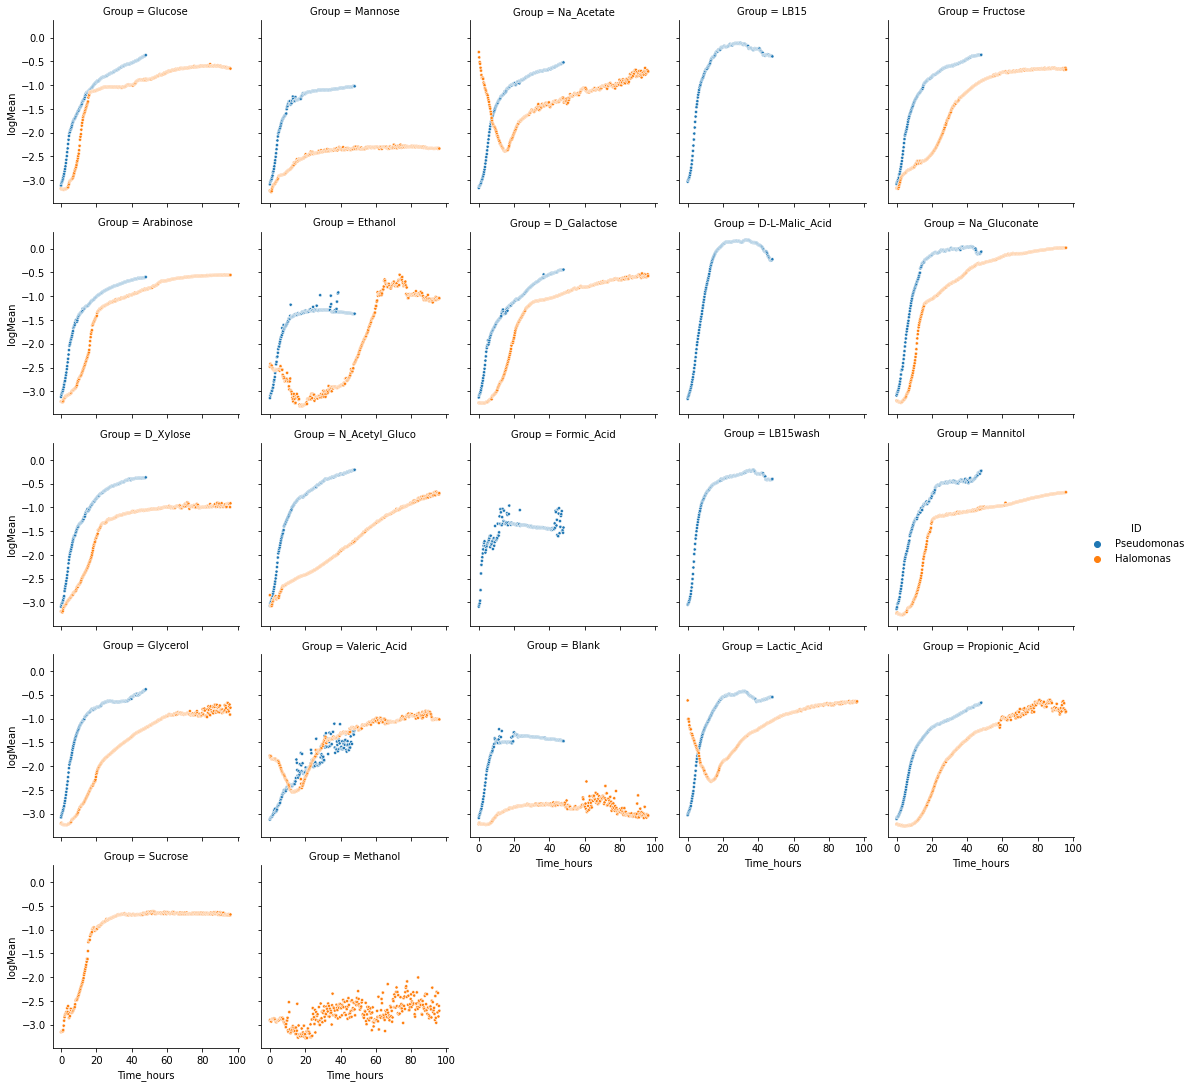

In [36]:
plate.show_comparison_to(plate2)